# Generative Adversarial Network

## Pre-processing data

In [149]:
import tensorflow as tf
import numpy as np
from IPython.display import Image
import matplotlib.image as mpimg
import os
tf.reset_default_graph()

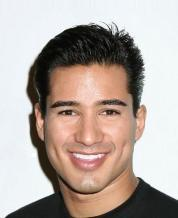

In [2]:
Image("img_align_celeba/000214.jpg") 

In [107]:
    
## Here we will get the 100 000 first images and put them in a variable 178*218*3
data_size = 25001
def get_data(data_size=25001):
        dataset = []
        for x in range(1, data_size):
            imgname = "img_align_celeba/"
            for i in range(0, 6-len(str(x))):
                imgname += "0"
            imgname += str(x) + ".jpg"
            print(imgname)
            dataset.append(mpimg.imread(imgname))
        dataset = np.array(dataset)
        return dataset
        
def get_batch(batch_size):
        indexes = np.random.randint(0, data_size)
        data = dataset[indexes]
        return data



print(np.array(dataset).shape)

In [150]:
def generator_mlp(Z, fc_sizes=[110,200,300], output_dim=218*178*3, reuse=False):
    
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        fc1 = tf.layers.dense(Z, fc_sizes[0], activation=tf.nn.leaky_relu)
        fc2 = tf.layers.dense(fc1, fc_sizes[1], activation=tf.nn.leaky_relu)
        fc3 = tf.layers.dense(fc2, fc_sizes[2], activation=tf.nn.leaky_relu)
        out = tf.layers.dense(fc3, output_dim)
    return out


In [151]:
def discriminator_mlp(X, fc_sizes=[110,300,200], reuse=False):
    
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,fc_sizes[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,fc_sizes[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,fc_sizes[2],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h3,1)

    return out, h3

In [152]:
X = tf.placeholder(tf.float32,[None,218,178,3])
Z = tf.placeholder(tf.float32,[None,2])

In [153]:
G_sample = generator_mlp(Z)
r_logits, r_rep = discriminator_mlp(X)
f_logits, g_rep = discriminator_mlp(G_sample, reuse=True)

ValueError: Trying to share variable GAN/Discriminator/dense/kernel, but specified shape (116412, 110) and found shape (3, 110).

In [ ]:
disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))
